# Plataformas y máquinas inteligentes en big data


Autora: Beatriz Ibarra Mendoza  
Última actualización: 22/01/2024  



Este notebook analiza datos relacionados con medio ambiente y contaminación en la ciudad de Monterrey utilizando PySpark, Pandas y Matplotlib. Asimismo, incluye modelos de regresión para la predicción de variables de interés que auxilien en la toma de decisiones. Se compone de la siguientes etapas:  

* *Instalación* de PySpark y otras paqueterías.  
* *Exploración* del conjunto de datos.  
* *Pre-procesamiento* de datos.  
* *Cálculo de correlaciones*.  
* *Confirmación* de correlaciones (visualización).  
* *Modelos de regresión*.



### Instalación

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [ ]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

### Exploración de datos

In [ ]:
mty_pollution = spark.read.csv('/content/Monterrey_Pollution_Data_2.csv', header=True,
                               sep=",", inferSchema=True)
mty_pollution.show(10)
type(mty_pollution)

+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.0

pyspark.sql.dataframe.DataFrame

In [ ]:
print('Número de registros: ' + str(mty_pollution.count()))
print('Número de columnas: ' + str(len(mty_pollution.columns)))

Número de registros: 3859
Número de columnas: 20


In [ ]:
# Estadísticos general del df.
mty_pollution.describe()

summary,Date,Month,Day,DayWeek,WeekDay,Hour,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SR,TOUT,WSR,WDV
count,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859
mean,null,4.820678932365898,15.76444674786214,null,4.075926405804613,12.037833635656906,1.8006219227779212,13.503653796320318,17.539284788381988,30.973257321216455,22.658719875615443,86.04949468774294,27.675822752008294,719.629955947137,0.002650945840632...,71.04845814977973,0.1825822752311473,22.0189686447266,7.331458927183208,127.52215599896346
stddev,null,2.8352877939176295,9.157213402989008,null,1.9730397456778965,6.869487540512553,0.8720340991225567,26.856244699079294,13.301006799154928,36.090498039388464,16.51056131885926,49.00887433131967,16.849434279135153,3.6959485297554657,0.04244711534165332,18.33461472259281,0.26160202836729035,7.545535084646807,3.8282164629573447,96.51530962028535
min,01-abr-15,1,1,dom,1,0,0.29,2.3,0.4,3.1,2,8,5,708.4,0.0,12,0.0,3.03,0.9,0
max,31/08/2015,11,31,vie,7,23,8.56,414.3,99.2,436.0,92,494,123,734.3,2.4,96,0.934,38.52,21.2,360


### Pre-procesamiento de datos

In [ ]:
# Eliminar variables innecesarias
cols = ['Date', 'Day', 'DayWeek', 'WeekDay']
mty_pollution_2 = mty_pollution.drop(*cols)

# Eliminar registros duplicados
mty_pollution_clean = mty_pollution_2.dropDuplicates()

Decidí eliminar las variables 'Date', 'Day', 'DayWeek' y 'WeekDay' porque no aportan información relevante respecto al incremento o decremento de la concentración de los contaminantes de interés. Considero que las variables 'Month' (para características estacionales) y 'Hour' (para establecer una relación con cantidad de tráfico) son suficientes para incluir en el modelo.

In [ ]:
mty_pollution_clean.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Month,3859,4.820678932365898,2.8352877939176304,1,11
Hour,3859,12.037833635656906,6.869487540512547,0,23
CO,3859,1.8006219227779223,0.8720340991225556,0.29,8.56
NO,3859,13.503653796320284,26.85624469907931,2.3,414.3
NO2,3859,17.539284788381963,13.301006799154921,0.4,99.2
NOX,3859,30.973257321216394,36.09049803938845,3.1,436.0
O3,3859,22.658719875615443,16.51056131885926,2,92
PM10,3859,86.04949468774294,49.00887433131958,8,494
PM2.5,3859,27.675822752008294,16.849434279135174,5,123


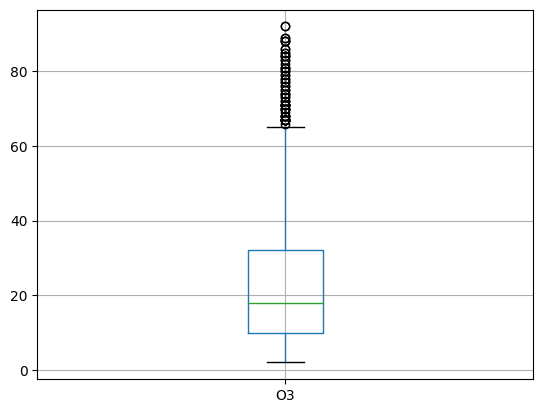

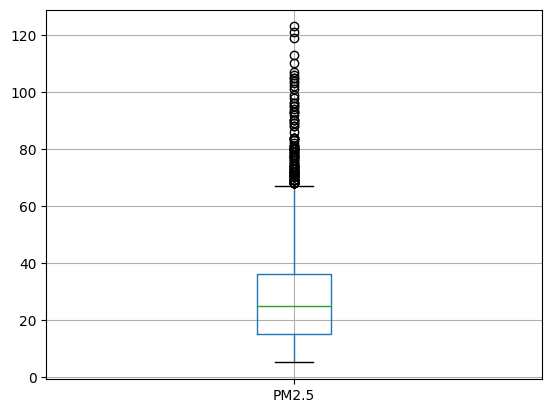

In [ ]:
# Exploración de distribución de datos o presencia de outliers en las variables de interés.
import pandas as pd
import matplotlib.pyplot as plt

mty_pollution_clean_pd = mty_pollution_clean.toPandas() # crea un df
mty_pollution_clean_pd.boxplot(column=['O3'])
plt.show()

mty_pollution_clean_pd.boxplot(column=['PM2.5'])
plt.show()

Los datos contenidos en las variables de interés no presentan una distribución normal y además cuentan con múltiples outliers. Esta información permite considerar el mejor método de correlación para la naturaleza de los datos.

### Correlaciones

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Cambio de nombre de columna ya que el '.' es un caracter especial y VectorAssembler no puede usarlo.
mty_pollution_clean = mty_pollution_clean.withColumnRenamed("PM2.5", "PM2_5")
vector_cols = 'corr_features'
assembler = VectorAssembler(inputCols=mty_pollution_clean.columns, outputCol=vector_cols)
mty_vector = assembler.transform(mty_pollution_clean)

In [ ]:
mty_vector.select(vector_cols).show(10, truncate=False)

+-----------------------------------------------------------------------------------+
|corr_features                                                                      |
+-----------------------------------------------------------------------------------+
|[1.0,17.0,2.82,7.8,31.8,39.6,36.0,105.0,21.0,726.8,0.0,66.0,0.036,15.98,6.7,105.0] |
|[1.0,22.0,3.36,18.9,52.8,71.7,9.0,174.0,33.0,724.9,0.0,69.0,0.0,12.4,4.0,109.0]    |
|[1.0,13.0,3.27,9.9,36.9,46.8,57.0,132.0,23.0,721.1,0.0,41.0,0.543,24.93,3.5,34.0]  |
|[1.0,15.0,3.44,9.5,46.8,56.3,63.0,91.0,41.0,720.7,0.0,42.0,0.304,24.46,6.0,98.0]   |
|[1.0,19.0,3.44,13.1,36.9,50.0,11.0,119.0,16.0,724.2,0.0,61.0,0.0,21.07,7.4,92.0]   |
|[2.0,21.0,2.17,19.6,36.1,55.7,5.0,36.0,9.0,724.5,0.01,94.0,0.0,8.04,2.4,51.0]      |
|[3.0,9.0,1.26,9.1,17.2,26.3,25.0,63.0,20.0,732.5,0.0,69.0,0.09,6.38,11.1,115.0]    |
|[3.0,18.0,1.73,6.0,13.6,19.6,32.0,88.0,53.0,719.4,0.0,70.0,0.028,24.5,14.3,116.0]  |
|[3.0,15.0,1.82,5.4,15.1,20.5,72.0,126.0,37.0,719.6,0.

In [ ]:
# Correlación método Spearman
corr_spearman = Correlation.corr(mty_vector, vector_cols, method='spearman')
print('Spearman Correlation Matrix\n', corr_spearman.collect()[0]["spearman({})".format(vector_cols)].values)

Spearman Correlation Matrix
 [ 1.00000000e+00  5.61378594e-04 -5.68964967e-01 -5.96012289e-01
 -6.89099554e-01 -6.96122375e-01  2.43576471e-01 -1.88967171e-01
  7.08157171e-03 -4.41821163e-01 -9.74134445e-02 -1.86296424e-01
  1.20081969e-01  7.15890721e-01  2.95830644e-01 -2.26584124e-01
  5.61378594e-04  1.00000000e+00  8.32254749e-02  1.53087172e-01
  8.80326413e-02  9.27599812e-02  2.41866779e-01  1.30756787e-01
  9.65543436e-02 -6.66523143e-02  1.06646444e-02 -3.63574627e-01
 -4.27505584e-03  2.39509582e-01  4.27276288e-01  6.29570164e-02
 -5.68964967e-01  8.32254749e-02  1.00000000e+00  6.17565699e-01
  6.80055880e-01  6.94912398e-01 -2.17435443e-01  2.15802666e-01
  1.25954393e-01  1.64567079e-01  7.00143476e-02  1.75340748e-01
 -8.31964589e-02 -4.46195351e-01 -3.21480229e-01  2.12671249e-01
 -5.96012289e-01  1.53087172e-01  6.17565699e-01  1.00000000e+00
  7.95137479e-01  8.90923738e-01 -3.79075351e-01  3.25608354e-01
  1.14356263e-01  2.61123237e-01  5.93745904e-02  1.20151555e

Elegí el método Spearman debido a la naturaleza de los datos. Este método es más robusto respecto al análisis con outliers y no hace suposiciones sobre la distribución de los datos (no muestran normalidad).

In [ ]:
# Establecer un arreglo
import numpy as np
spearman_array = np.matrix(corr_spearman.collect()[0]["spearman({})".format(vector_cols)].values).reshape(16,16)

[Text(0.5, 0, 'Month'),
 Text(1.5, 0, 'Hour'),
 Text(2.5, 0, 'CO'),
 Text(3.5, 0, 'NO'),
 Text(4.5, 0, 'NO2'),
 Text(5.5, 0, 'NOX'),
 Text(6.5, 0, 'O3'),
 Text(7.5, 0, 'PM10'),
 Text(8.5, 0, 'PM2_5'),
 Text(9.5, 0, 'PRS'),
 Text(10.5, 0, 'RAINF'),
 Text(11.5, 0, 'RH'),
 Text(12.5, 0, 'SR'),
 Text(13.5, 0, 'TOUT'),
 Text(14.5, 0, 'WSR'),
 Text(15.5, 0, 'WDV')]

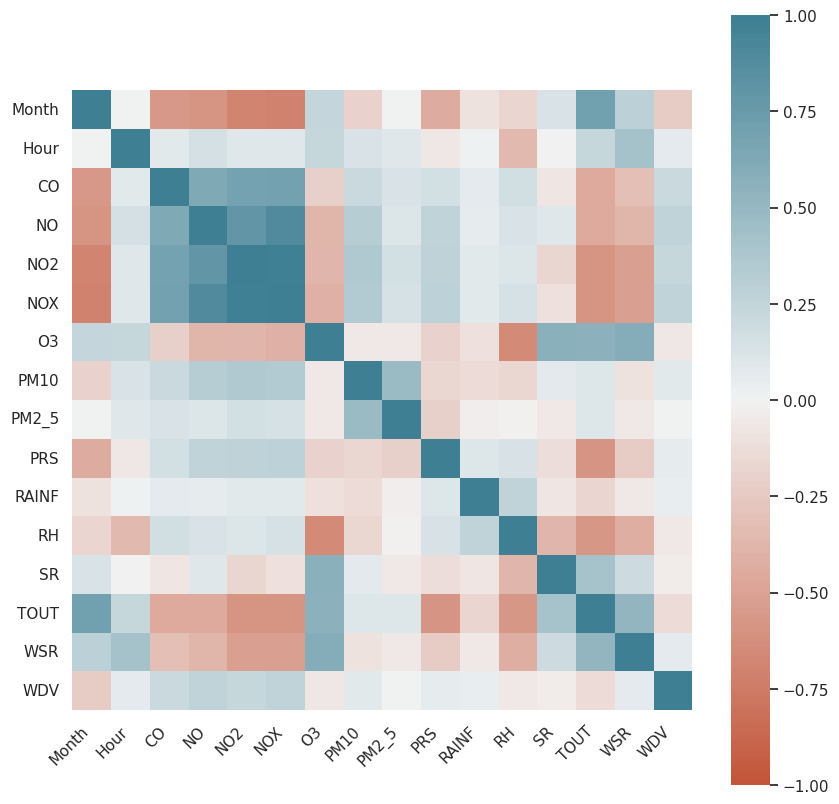

In [ ]:
# Visualización con seaborn
import seaborn as sns
import numpy as np

vis_columns = mty_pollution_clean.columns

sns.set(color_codes=True, font_scale=1.0)
plt.figure(figsize=(10,10)) # Tamaño de figura

# Convertir df
spearman_matrix = pd.DataFrame(data=spearman_array, index=vis_columns, columns=vis_columns)

ax = sns.heatmap(
    spearman_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [ ]:
# Visualización con plotly
import plotly.express as px

spearman_array = np.matrix(corr_spearman.collect()[0]["spearman({})".format(vector_cols)].values).reshape(16,16)
fig = px.imshow(spearman_array)
fig.show()

Descripción de correlaciones encontradas con las variables de O3 y PM2.5:

* Respecto a la concentración de ozono se encontró una variable correlacionada negativamente y 3 de forma positiva. En todos los casos las correlaciones son 'moderadas'. Se enlistan a continuación:  
    - Humedad relativa (RH, -0,65): señala que conforme incrementa el % de humedad, la concentración de ozono disminuye, y viceversa.  
    - Velocidad del viento (WSR, 0.59), radiación solar (SR, 0.57), temperatura (TOUT, 0.55): los valores de correlación indican que conforme incrementan estos parámetros ambientales, la concentración de ozono también incrementará.  
* Respecto a las partículas < 2.5 microns no se encontraron variables correlacionadas negativamente, solo una positiva. Sin embargo, esta correlación también es 'moderada':  
    - Partículas < 10 microns (PM10, 0.48): conforme incrementa la concentración de estas partículas, también incrementa la concentración de las partículas < 2.5 microns (lo cual podría inferirse incluso sin un análisis de correlación).


### Confirmación de correlaciones (scatter plots)

In [ ]:
# Seleccionar data
ozone = mty_pollution_clean.select('O3')
wind_speed = mty_pollution_clean.select('WSR')
solar_radiation = mty_pollution_clean.select('SR')
temp = mty_pollution_clean.select('TOUT')
pm25 = mty_pollution_clean.select('PM2_5')
pm10 = mty_pollution_clean.select('PM10')
rel_humidity = mty_pollution_clean.select('RH')

In [ ]:
# Crear arreglos
ozone = ozone.rdd.map(lambda row : row.O3)
wind_speed = wind_speed.rdd.map(lambda row : row.WSR)
solar_radiation = solar_radiation.rdd.map(lambda row : row.SR)
temp = temp.rdd.map(lambda row : row.TOUT)
pm25 = pm25.rdd.map(lambda row : row.PM2_5)
pm10 = pm10.rdd.map(lambda row : row.PM10)
rel_humidity = rel_humidity.rdd.map(lambda row : row.RH)

ozone_array = ozone.collect()
wind_speed_array = wind_speed.collect()
solar_rad_array = solar_radiation.collect()
temp_array = temp.collect()
pm25_array = pm25.collect()
pm10_array = pm10.collect()
hum_array = rel_humidity.collect()

In [ ]:
print(len(ozone_array), len(wind_speed_array)) # Confirmar el tamaño

3859 3859


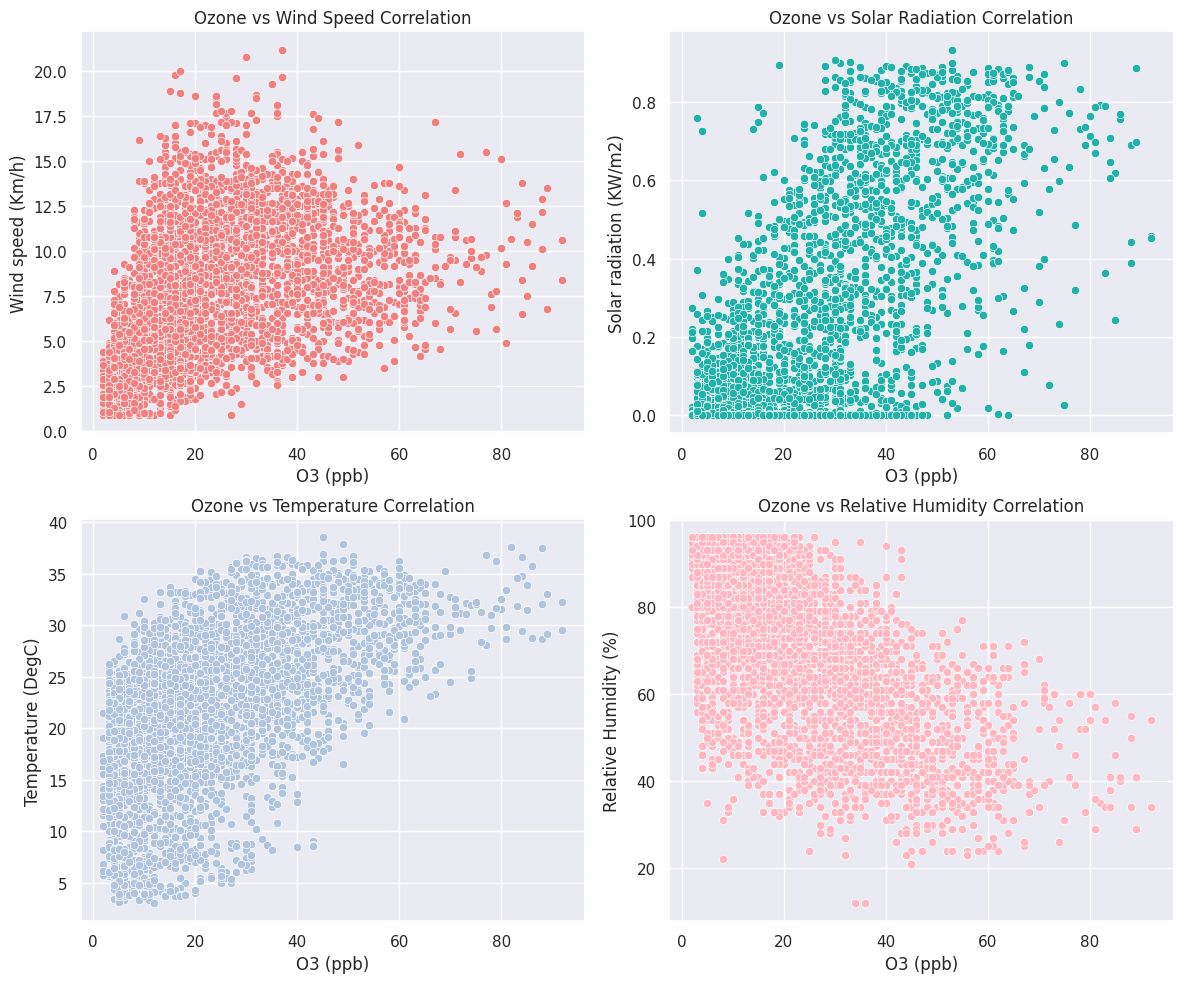

In [ ]:
# Plots para correlacionar variables con concentración de ozono.

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

sns.scatterplot(x=ozone_array, y=wind_speed_array, color='lightcoral', ax=axes[0,0])
axes[0,0].set_title('Ozone vs Wind Speed Correlation')
axes[0,0].set_xlabel('O3 (ppb)')
axes[0,0].set_ylabel('Wind speed (Km/h)')

sns.scatterplot(x=ozone_array, y=solar_rad_array, color='lightseagreen', ax=axes[0,1])
axes[0,1].set_title('Ozone vs Solar Radiation Correlation')
axes[0,1].set_xlabel('O3 (ppb)')
axes[0,1].set_ylabel('Solar radiation (KW/m2)')

sns.scatterplot(x=ozone_array, y=temp_array, color='lightsteelblue', ax=axes[1,0])
axes[1,0].set_title('Ozone vs Temperature Correlation')
axes[1,0].set_xlabel('O3 (ppb)')
axes[1,0].set_ylabel('Temperature (DegC)')

sns.scatterplot(x=ozone_array, y=hum_array, color='lightpink', ax=axes[1,1])
axes[1,1].set_title('Ozone vs Relative Humidity Correlation')
axes[1,1].set_xlabel('O3 (ppb)')
axes[1,1].set_ylabel('Relative Humidity (%)')

plt.tight_layout(h_pad=0.7)

plt.show()

Se confirman las correlaciones positivas entre el ozono y velocidad del viento, temperatura y radiación solar. Asimismo, se confirma la correlación negativa respecto al % de humedad relativa.

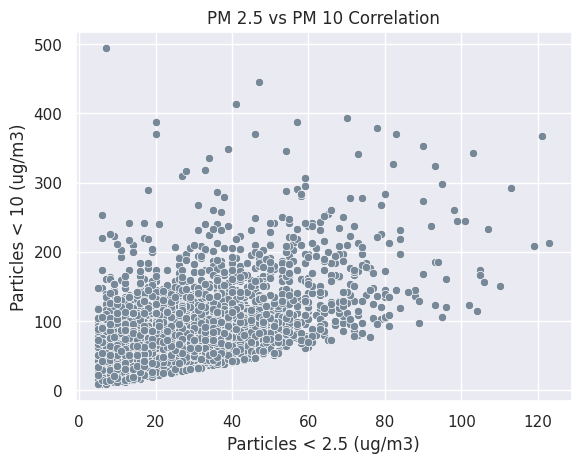

In [ ]:
# Plot para correlacionar variable con concentración de partículas < 2.5 microns.

sns.scatterplot(x=pm25_array, y=pm10_array, color='lightslategrey')
plt.title('PM 2.5 vs PM 10 Correlation')
plt.xlabel('Particles < 2.5 (ug/m3)')
plt.ylabel('Particles < 10 (ug/m3)')


plt.show()

Se confirma la correlación positiva entre la concentración de partículas < 2.5 microns y partículas < 10 microns.

### Modelos de regresión

#### Predicción para concentración de ozono

In [ ]:
# Ensamblar vectores de datos

assembler2 = VectorAssembler(inputCols=['Hour', 'CO', 'NOX', 'PM10', 'WSR', 'WDV',
                                        'TOUT', 'SR', 'RAINF'], outputCol='Attributes')
output = assembler2.transform(mty_pollution_clean)

In [ ]:
# Data final (para modelos de ozono)

data_pollution_model_1 = output.select('Attributes', 'O3')
data_pollution_model_1.show(10)

+--------------------+---+
|          Attributes| O3|
+--------------------+---+
|[17.0,2.82,39.6,1...| 36|
|[22.0,3.36,71.7,1...|  9|
|[13.0,3.27,46.8,1...| 57|
|[15.0,3.44,56.3,9...| 63|
|[19.0,3.44,50.0,1...| 11|
|[21.0,2.17,55.7,3...|  5|
|[9.0,1.26,26.3,63...| 25|
|[18.0,1.73,19.6,8...| 32|
|[15.0,1.82,20.5,1...| 72|
|[22.0,2.03,32.1,1...| 14|
+--------------------+---+
only showing top 10 rows



In [ ]:
# Partición de data

train_data, test_data = data_pollution_model_1.randomSplit([0.8,0.2])

In [ ]:
# Regresión lineal

from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(featuresCol='Attributes', labelCol='O3')
regressor = regressor.fit(train_data)

print('El coeficiente del modelo es: ', regressor.coefficients)
print('El intercepto del modelo es: ', regressor.intercept)

El coeficiente del modelo es:  [0.09419657293247813,3.203600267259413,-0.06656091647349135,-0.016490783464620316,1.0744222369802128,-0.008897828647938718,0.3310698758759371,36.11914404101412,-1.380596435541523]
El intercepto del modelo es:  -1.2532645805679115


In [ ]:
# Predicciones con datos de prueba
pred_lr_ozone = regressor.evaluate(test_data)
pred_lr_ozone.predictions.show(10)

+--------------------+---+------------------+
|          Attributes| O3|        prediction|
+--------------------+---+------------------+
|[12.0,2.13,21.7,5...| 25| 17.43688619522919|
|[21.0,2.17,55.7,3...|  5|  8.14838472406201|
|[22.0,2.03,32.1,1...| 14|17.669388057939276|
|[1.0,1.72,11.6,49...| 28|17.406685079852245|
|[22.0,0.9,8.60000...| 20|24.092351901166733|
|[1.0,3.26,148.9,2...|  3|12.564054650559173|
|[5.0,0.81,13.1000...| 10| 8.874070513557799|
|[6.0,2.06,42.7,94...|  4|11.302476824641417|
|[7.0,1.2,20.1,73....|  7|16.922535450244744|
|[11.0,2.02,32.8,4...|  9|16.229264643520217|
+--------------------+---+------------------+
only showing top 10 rows



In [ ]:
# Bosque aleatorio

from pyspark.ml.regression import RandomForestRegressor

rf_regressor = RandomForestRegressor(featuresCol='Attributes', labelCol='O3')
rf_regressor = rf_regressor.fit(train_data) # Entrenamiento
pred_rfr = rf_regressor.transform(test_data) # Predicciones con datos de prueba

pred_rfr.select('Attributes', 'O3', 'prediction').show(10)

+--------------------+---+------------------+
|          Attributes| O3|        prediction|
+--------------------+---+------------------+
|[12.0,2.13,21.7,5...| 25|21.688043578791543|
|[21.0,2.17,55.7,3...|  5| 8.618726254401508|
|[22.0,2.03,32.1,1...| 14|18.199155764671623|
|[1.0,1.72,11.6,49...| 28| 19.49341713379902|
|[22.0,0.9,8.60000...| 20|19.737255455330885|
|[1.0,3.26,148.9,2...|  3|11.843826310000605|
|[5.0,0.81,13.1000...| 10|11.764279828859346|
|[6.0,2.06,42.7,94...|  4| 7.961102527747899|
|[7.0,1.2,20.1,73....|  7|12.855092545220959|
|[11.0,2.02,32.8,4...|  9|18.964777617808835|
+--------------------+---+------------------+
only showing top 10 rows



In [ ]:
# Gradient Boost Trees

from pyspark.ml.regression import GBTRegressor

boost_regressor = GBTRegressor(featuresCol = 'Attributes', labelCol = 'O3')
boost_regressor = boost_regressor.fit(train_data) # Entrenamiento
pred_gbt = boost_regressor.transform(test_data) # Predicciones con datos de prueba

pred_gbt.select('Attributes', 'O3', 'prediction').show(10)

+--------------------+---+------------------+
|          Attributes| O3|        prediction|
+--------------------+---+------------------+
|[12.0,2.13,21.7,5...| 25|14.182336478102622|
|[21.0,2.17,55.7,3...|  5|3.9181966013543637|
|[22.0,2.03,32.1,1...| 14|18.442203484969372|
|[1.0,1.72,11.6,49...| 28| 19.94229693477733|
|[22.0,0.9,8.60000...| 20| 17.67476809488028|
|[1.0,3.26,148.9,2...|  3| 8.380217597248349|
|[5.0,0.81,13.1000...| 10|12.490246960779386|
|[6.0,2.06,42.7,94...|  4|  4.34532138135817|
|[7.0,1.2,20.1,73....|  7| 8.579874545891192|
|[11.0,2.02,32.8,4...|  9|22.842989347418886|
+--------------------+---+------------------+
only showing top 10 rows



In [ ]:
# Evaluación de regresión lineal

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluation = RegressionEvaluator(labelCol='O3', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de regresión lineal \n")

# Root Mean Square Error
rmse_lr = lr_evaluation.evaluate(pred_lr_ozone.predictions)
print("RMSE: %.3f" % rmse_lr)

# Mean Square Error
mse_lr = lr_evaluation.evaluate(pred_lr_ozone.predictions, {lr_evaluation.metricName: "mse"})
print("MSE: %.3f" % mse_lr)

# Mean Absolute Error
mae_lr = lr_evaluation.evaluate(pred_lr_ozone.predictions, {lr_evaluation.metricName: "mae"})
print("MAE: %.3f" % mae_lr)

# r2 - coefficient of determination
r2_lr = lr_evaluation.evaluate(pred_lr_ozone.predictions, {lr_evaluation.metricName: "r2"})
print("r2: %.3f" %r2_lr)

Modelo de regresión lineal 

RMSE: 9.923
MSE: 98.467
MAE: 7.623
r2: 0.618


In [ ]:
# Evaluación de random forest

rf_evaluation = RegressionEvaluator(labelCol='O3', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de regresión bosque aleatorio \n")

# Root Mean Square Error
rmse_rf = rf_evaluation.evaluate(pred_rfr)
print("RMSE: %.3f" % rmse_rf)

# Mean Square Error
mse_rf = rf_evaluation.evaluate(pred_rfr, {rf_evaluation.metricName: "mse"})
print("MSE: %.3f" % mse_rf)

# Mean Absolute Error
mae_rf = rf_evaluation.evaluate(pred_rfr, {rf_evaluation.metricName: "mae"})
print("MAE: %.3f" % mae_rf)

# r2 - coefficient of determination
r2_rf = rf_evaluation.evaluate(pred_rfr, {rf_evaluation.metricName: "r2"})
print("r2: %.3f" %r2_rf)

Modelo de regresión bosque aleatorio 

RMSE: 8.482
MSE: 71.942
MAE: 6.255
r2: 0.721


In [ ]:
# Evaluación de gradient boost trees

gbt_evaluation = RegressionEvaluator(labelCol='O3', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de gradient boost trees \n")

# Root Mean Square Error
rmse_gbt = gbt_evaluation.evaluate(pred_gbt)
print("RMSE: %.3f" % rmse_gbt)

# Mean Square Error
mse_gbt = gbt_evaluation.evaluate(pred_gbt, {gbt_evaluation.metricName: "mse"})
print("MSE: %.3f" % mse_gbt)

# Mean Absolute Error
mae_gbt = gbt_evaluation.evaluate(pred_gbt, {gbt_evaluation.metricName: "mae"})
print("MAE: %.3f" % mae_gbt)

# r2 - coefficient of determination
r2_gbt = gbt_evaluation.evaluate(pred_gbt, {gbt_evaluation.metricName: "r2"})
print("r2: %.3f" %r2_gbt)

Modelo de gradient boost trees 

RMSE: 8.096
MSE: 65.538
MAE: 5.895
r2: 0.746


Se eligieron las variables Hora, monóxido de carbono, suma de NO y NO2, partículas < 10 microns, velocidad del viento, dirección del viento, temperatura, radiación solar y lluvia ('Hour', 'CO', 'NOX', 'PM10', 'WSR', 'WDV', 'TOUT', 'SR', 'RAINF', respectivamente) para entrenar los modelos de regresión y obtener predicciones respecto a la variable de interés (concentración de ozono).  
De acuerdo con las métricas de evaluación, el mejor modelo para predecir la concentración de ozono en Monterrey es gradient boost trees.

#### Predicción para concentración de partículas menores a 2.5 microns

In [ ]:
# Data final (para modelos de pm < 2.5)

data_pollution_model_2 = output.select('Attributes', 'PM2_5')
data_pollution_model_2.show(10)

+--------------------+-----+
|          Attributes|PM2_5|
+--------------------+-----+
|[17.0,2.82,39.6,1...|   21|
|[22.0,3.36,71.7,1...|   33|
|[13.0,3.27,46.8,1...|   23|
|[15.0,3.44,56.3,9...|   41|
|[19.0,3.44,50.0,1...|   16|
|[21.0,2.17,55.7,3...|    9|
|[9.0,1.26,26.3,63...|   20|
|[18.0,1.73,19.6,8...|   53|
|[15.0,1.82,20.5,1...|   37|
|[22.0,2.03,32.1,1...|    7|
+--------------------+-----+
only showing top 10 rows



In [ ]:
# Partición de data
train_data2, test_data2 = data_pollution_model_2.randomSplit([0.8,0.2])

In [ ]:
# Regresión lineal

regressor2 = LinearRegression(featuresCol='Attributes', labelCol='PM2_5')
regressor2 = regressor2.fit(train_data2)

print('El coeficiente del modelo es: ', regressor2.coefficients)
print('El intercepto del modelo es: ', regressor2.intercept)

El coeficiente del modelo es:  [0.10839152041848894,0.9392794735145622,0.014475735643193086,0.15740499957926377,-0.16712276737811355,-0.00796384459429639,0.298119625830149,-6.696187057415176,16.813246498477273]
El intercepto del modelo es:  7.480497517786079


In [ ]:
# Predicciones con datos de prueba
pred_lr_pm25 = regressor2.evaluate(test_data2)
pred_lr_pm25.predictions.show(10)

+--------------------+-----+------------------+
|          Attributes|PM2_5|        prediction|
+--------------------+-----+------------------+
|[12.0,2.13,21.7,5...|   13| 19.82684995237216|
|[15.0,0.83,11.9,5...|   27| 21.65275320731088|
|[15.0,2.07,14.3,6...|   43|26.233459776704628|
|[18.0,2.07,15.0,5...|   11| 24.83653061406548|
|[1.0,1.72,11.6,49...|   18|20.738149466748176|
|[9.0,1.86,19.5,82...|   53| 28.28851902104727|
|[9.0,2.65,49.9,48...|   27| 20.41299129103993|
|[17.0,1.97,18.3,7...|   26|26.520922652123765|
|[19.0,2.21,44.5,9...|   17|27.957904541186224|
|[6.0,2.06,42.7,94...|   36|  28.6050097484746|
+--------------------+-----+------------------+
only showing top 10 rows



In [ ]:
# Bosque aleatorio

rf_pm25 = RandomForestRegressor(featuresCol='Attributes', labelCol='PM2_5')
rf_pm25 = rf_pm25.fit(train_data2) # Entrenamiento
pred_rfr_pm25 = rf_pm25.transform(test_data2) # Predicciones con datos de prueba

pred_rfr_pm25.select('Attributes', 'PM2_5', 'prediction').show(10)

+--------------------+-----+------------------+
|          Attributes|PM2_5|        prediction|
+--------------------+-----+------------------+
|[12.0,2.13,21.7,5...|   13|20.399900683980476|
|[15.0,0.83,11.9,5...|   27|24.323562667094194|
|[15.0,2.07,14.3,6...|   43| 24.83820543520313|
|[18.0,2.07,15.0,5...|   11| 25.12407925820613|
|[1.0,1.72,11.6,49...|   18| 22.04726075765526|
|[9.0,1.86,19.5,82...|   53|25.754650518993014|
|[9.0,2.65,49.9,48...|   27|21.858174501900546|
|[17.0,1.97,18.3,7...|   26|27.563034296644684|
|[19.0,2.21,44.5,9...|   17| 26.64095291335361|
|[6.0,2.06,42.7,94...|   36|31.180808045872237|
+--------------------+-----+------------------+
only showing top 10 rows



In [ ]:
# Gradient Boost Trees

gbt_pm25 = GBTRegressor(featuresCol = 'Attributes', labelCol = 'PM2_5')
gbt_pm25 = gbt_pm25.fit(train_data2) # Entrenamiento
pred_gbt_pm25 = gbt_pm25.transform(test_data2) # Predicciones con datos de prueba

pred_gbt_pm25.select('Attributes', 'PM2_5', 'prediction').show(10)

+--------------------+-----+------------------+
|          Attributes|PM2_5|        prediction|
+--------------------+-----+------------------+
|[12.0,2.13,21.7,5...|   13| 20.08566669627989|
|[15.0,0.83,11.9,5...|   27|20.253744614271962|
|[15.0,2.07,14.3,6...|   43| 24.93366588847156|
|[18.0,2.07,15.0,5...|   11|24.673910332086507|
|[1.0,1.72,11.6,49...|   18| 16.74668893224981|
|[9.0,1.86,19.5,82...|   53| 25.83480068810319|
|[9.0,2.65,49.9,48...|   27|23.935898993902455|
|[17.0,1.97,18.3,7...|   26| 29.60632980271874|
|[19.0,2.21,44.5,9...|   17| 25.65893615974732|
|[6.0,2.06,42.7,94...|   36|28.826151692217344|
+--------------------+-----+------------------+
only showing top 10 rows



In [ ]:
# Evaluación de regresión lineal

lr_eval_pm25 = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de regresión lineal \n")

# Root Mean Square Error
rmse_lr_pm25 = lr_eval_pm25.evaluate(pred_lr_pm25.predictions)
print("RMSE: %.3f" % rmse_lr_pm25)

# Mean Square Error
mse_lr_pm25 = lr_eval_pm25.evaluate(pred_lr_pm25.predictions, {lr_eval_pm25.metricName: "mse"})
print("MSE: %.3f" % mse_lr_pm25)

# Mean Absolute Error
mae_lr_pm25 = lr_eval_pm25.evaluate(pred_lr_pm25.predictions, {lr_eval_pm25.metricName: "mae"})
print("MAE: %.3f" % mae_lr_pm25)

# r2 - coefficient of determination
r2_lr_pm25 = lr_eval_pm25.evaluate(pred_lr_pm25.predictions, {lr_eval_pm25.metricName: "r2"})
print("r2: %.3f" %r2_lr_pm25)

Modelo de regresión lineal 

RMSE: 14.471
MSE: 209.422
MAE: 10.928
r2: 0.304


In [ ]:
# Evaluación de random forest

rf_eval_pm25 = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de regresión bosque aleatorio \n")

# Root Mean Square Error
rmse_rf_pm25 = rf_eval_pm25.evaluate(pred_rfr_pm25)
print("RMSE: %.3f" % rmse_rf_pm25)

# Mean Square Error
mse_rf_pm25 = rf_eval_pm25.evaluate(pred_rfr_pm25, {rf_eval_pm25.metricName: "mse"})
print("MSE: %.3f" % mse_rf_pm25)

# Mean Absolute Error
mae_rf_pm25 = rf_eval_pm25.evaluate(pred_rfr_pm25, {rf_eval_pm25.metricName: "mae"})
print("MAE: %.3f" % mae_rf_pm25)

# r2 - coefficient of determination
r2_rf_pm25 = rf_eval_pm25.evaluate(pred_rfr_pm25, {rf_eval_pm25.metricName: "r2"})
print("r2: %.3f" %r2_rf_pm25)

Modelo de regresión bosque aleatorio 

RMSE: 14.433
MSE: 208.301
MAE: 11.083
r2: 0.308


In [ ]:
# Evaluación de gradient boost trees

gbt_eval_pm25 = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction',
                                    metricName='rmse')

print("Modelo de gradient boost trees \n")

# Root Mean Square Error
rmse_gbt_pm25 = gbt_eval_pm25.evaluate(pred_gbt_pm25)
print("RMSE: %.3f" % rmse_gbt_pm25)

# Mean Square Error
mse_gbt_pm25 = gbt_eval_pm25.evaluate(pred_gbt_pm25, {gbt_eval_pm25.metricName: "mse"})
print("MSE: %.3f" % mse_gbt_pm25)

# Mean Absolute Error
mae_gbt_pm25 = gbt_eval_pm25.evaluate(pred_gbt_pm25, {gbt_eval_pm25.metricName: "mae"})
print("MAE: %.3f" % mae_gbt_pm25)

# r2 - coefficient of determination
r2_gbt_pm25 = gbt_eval_pm25.evaluate(pred_gbt_pm25, {gbt_eval_pm25.metricName: "r2"})
print("r2: %.3f" %r2_gbt_pm25)

Modelo de gradient boost trees 

RMSE: 13.965
MSE: 195.009
MAE: 10.611
r2: 0.352


Se eligieron las variables Hora, monóxido de carbono, suma de NO y NO2, partículas < 10 microns, velocidad del viento, dirección del viento, temperatura, radiación solar y lluvia ('Hour', 'CO', 'NOX', 'PM10', 'WSR', 'WDV', 'TOUT', 'SR', 'RAINF', respectivamente) para entrenar los modelos de regresión y obtener predicciones respecto a la variable de interés (concentración de partículas menores a 2.5 microns).  
De acuerdo con las métricas de evaluación, el mejor modelo para predecir la concentración de estas partículas en Monterrey es gradient boost trees, sin embargo, como esta variable no tiene una correlación alta (positiva o negativa) respecto a los demás atributos del conjunto de datos, haría algunas recomendaciones:  
- Resolver desde el inicio los outliers de esta variable dependiente, con ingeniería de características y modelos estadísticos robustos.  
- Aplicar otros modelos que se ajusten mejor a la naturaleza de estos datos.  
- Crear nuevas combinaciones de vectores con otros atributos.

### Conclusiones

* ¿Podemos decir que la contaminación por O3 o PM2.5 está ligada al tráfico vehicular?, ¿tendría efectos sobre la contaminación implantar un esquema de verificación vehicular?  

Después de los análisis correspondientes en este conjunto de datos no se determinó que las variables de interés se relacionaran positiva o negativamente con el atributo 'Hora', el cual podría ser un indicador de la cantidad de tráfico a lo largo del día. Sin embargo, podrían incluirse otros atributos cuantificables asociados al tráfico en este conjunto de datos para averiguar si existe una correlación. De cualquier forma, en términos de contaminación general, un esquema de verificación vehicular en una ciudad como Monterrey sería beneficioso.  



* Dado un reporte del pronóstico del clima dado en la mañana, ¿podemos predecir que habrá una contingencia ambiental debido a que los contaminantes en el aire rebasarán los límites permitidos por la norma?

Sí. Un pronóstico del clima que incluya información sobre la radiación solar, la velocidad y dirección del viento, así como la temperatura, podría permitir la predicción de contingencias ambientales a lo largo del día.  
  

  
* ¿Qué condiciones climáticas se deben cumplir para tener altos niveles de contaminación de O3 y PM 2.5?  

Es una combinación de varios factores climáticos, por ejemplo, radiación solar mayor a 0.8 KW/m2, velocidad del viento mayor a 12 Km/h, temperatura mayor a 30ºC (lo cual podría ser frecuente en Mty) y un porcentaje de humedad entre 20 y 40%.  
En el caso de los límites permisibles para las partículas menores a 2.5 microns, las partículas < 10 microns no debería sobrepasar los 100 ug/m3.


